In [1]:
from nowcasting_dataset.datamodule import NowcastingDataModule
from pathlib import Path

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl

In [3]:
BUCKET = Path('solar-pv-nowcasting-data')

# Solar PV data
PV_PATH = BUCKET / 'PV/PVOutput.org'
PV_DATA_FILENAME = PV_PATH / 'UK_PV_timeseries_batch.nc'
PV_METADATA_FILENAME = PV_PATH / 'UK_PV_metadata.csv'

# SAT_FILENAME = BUCKET / 'satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr_int16_single_timestep_quarter_geospatial.zarr'
SAT_FILENAME = BUCKET / 'satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr_int16_single_timestep.zarr'

In [4]:
%%time
data_module = NowcastingDataModule(
    #pv_power_filename=PV_DATA_FILENAME,
    pv_metadata_filename=f'gs://{PV_METADATA_FILENAME}',
    batch_size = 32,
    history_len = 0,  #: Number of timesteps of history, not including t0.
    forecast_len = 1,  #: Number of timesteps of forecast.
    sat_filename = f'gs://{SAT_FILENAME}',
    sat_channels = None, #('HRV', 'WV_062', 'WV_073'),
    pin_memory = True,  #: Passed to DataLoader.
    num_workers = 8,  #: Passed to DataLoader.
    prefetch_factor = 256,  #: Passed to DataLoader.
    n_samples_per_timestep = 16,  #: Passed to NowcastingDataset
)

CPU times: user 58 µs, sys: 9 µs, total: 67 µs
Wall time: 69.9 µs


In [5]:
data_module.prepare_data()

In [6]:
data_module.setup()

In [7]:
dl = data_module.train_dataloader()

In [8]:
%%time
dl.dataset.per_worker_init(worker_id=0)

CPU times: user 1.55 s, sys: 43.9 ms, total: 1.59 s
Wall time: 1.73 s


In [9]:
%%time
batch_delayed = dl.dataset._get_batch()

CPU times: user 72.2 ms, sys: 163 µs, total: 72.4 ms
Wall time: 70.5 ms


In [10]:
batch_delayed[0]['sat_data'].chunks

Delayed('getattr-5a7511f59b44ecb97fd484005fb09bc5')

In [11]:
import dask

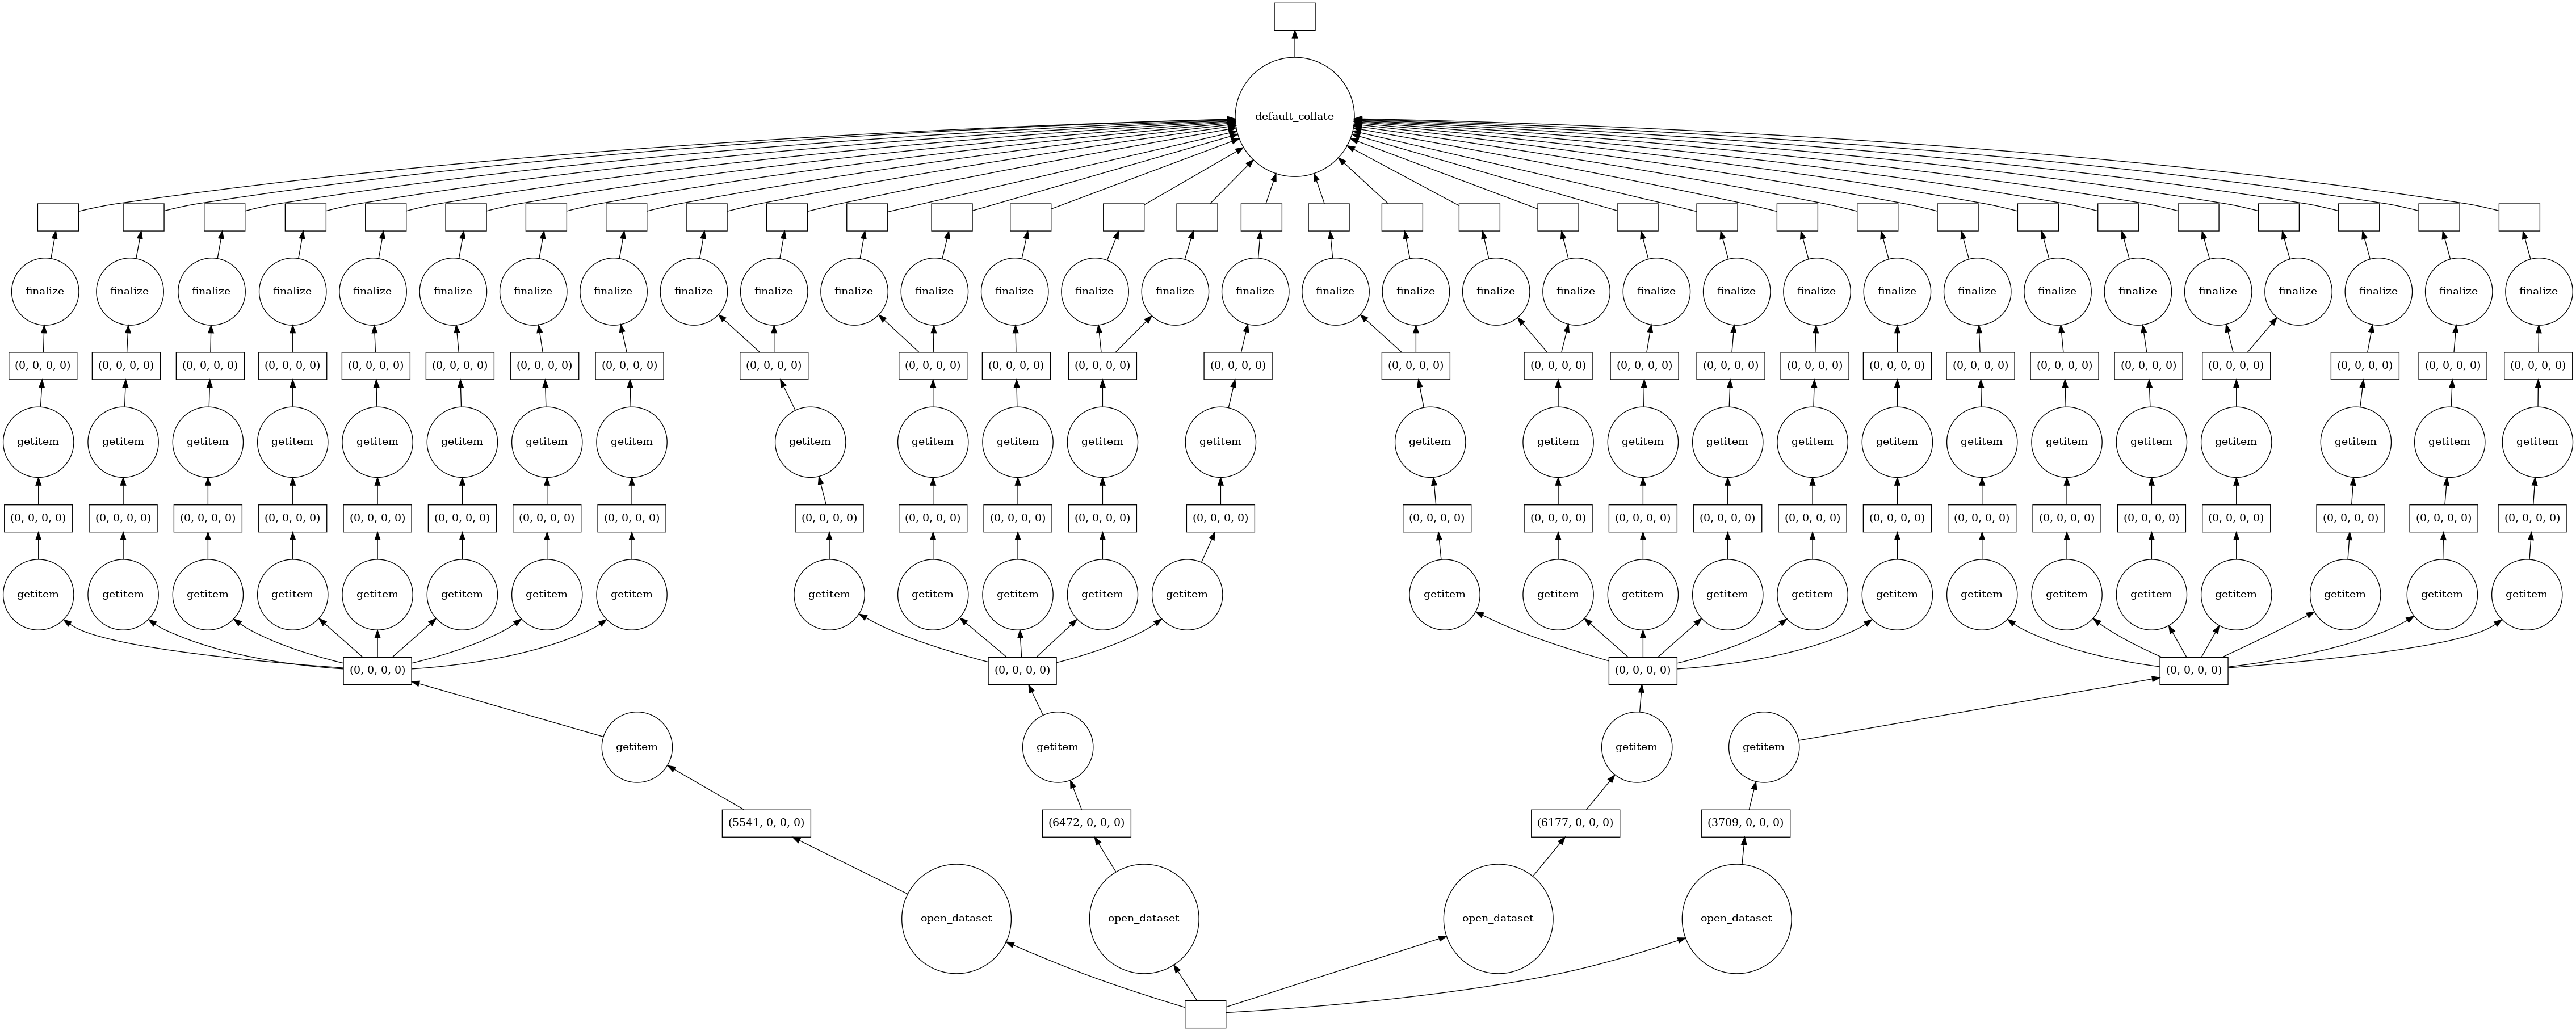

In [12]:
dask.visualize(batch_delayed, optimize_graph=True)

In [13]:
%%time
batch = dask.compute(batch_delayed)

CPU times: user 2.22 s, sys: 402 ms, total: 2.62 s
Wall time: 1.65 s


In [20]:
%%time
batch[0][2]['sat_data']

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


<xarray.DataArray 'stacked_eumetsat_data' (time: 2, y: 128, x: 128, variable: 12)>
array([[[[570, 663, 901, ..., 606, 635, 494],
         [573, 669, 901, ..., 602, 635, 499],
         [565, 678, 902, ..., 602, 636, 501],
         ...,
         [363, 531, 890, ..., 424, 576, 467],
         [381, 548, 890, ..., 438, 587, 472],
         [413, 540, 886, ..., 440, 598, 472]],

        [[565, 660, 899, ..., 603, 636, 492],
         [565, 668, 901, ..., 598, 636, 500],
         [567, 681, 903, ..., 599, 636, 504],
         ...,
         [341, 523, 881, ..., 423, 570, 455],
         [368, 544, 881, ..., 440, 578, 458],
         [404, 536, 877, ..., 443, 587, 457]],

        [[566, 662, 897, ..., 601, 636, 488],
         [556, 669, 900, ..., 596, 637, 498],
         [563, 680, 902, ..., 595, 637, 504],
         ...,
...
         ...,
         [446, 348, 826, ..., 448, 552, 402],
         [422, 375, 834, ..., 450, 550, 409],
         [427, 398, 836, ..., 458, 550, 412]],

        [[516, 314, 814, ..., 557, 672, 487],
         [517, 314, 819, ..., 579, 673, 493],
         [548, 317, 821, ..., 610, 672, 506],
         ...,
         [473, 337, 817, ..., 462, 552, 398],
         [452, 362, 828, ..., 457, 553, 405],
         [442, 389, 835, ..., 455, 554, 409]],

        [[501, 328, 818, ..., 546, 672, 488],
         [511, 326, 823, ..., 568, 673, 494],
         [521, 327, 825, ..., 603, 672, 508],
         ...,
         [489, 326, 809, ..., 478, 551, 393],
         [477, 348, 820, ..., 469, 554, 401],
         [467, 377, 830, ..., 459, 556, 406]]]], dtype=int16)
Coordinates:
  * time      (time) datetime64[ns] 2018-07-27T12:55:00 2018-07-27T13:00:00
  * variable  (variable) <U6 'HRV' 'IR_016' 'IR_039' ... 'WV_062' 'WV_073'
  * x         (x) int64 -28000 -26000 -24000 -22000 ... 222000 224000 226000
  * y         (y) int64 228000 226000 224000 222000 ... -22000 -24000 -26000

## Define very simple ML model

In [5]:
def normalise_images_in_model(images, device):
    SAT_IMAGE_MEAN = torch.tensor(
        [
            93.23458, 131.71373, 843.7779 , 736.6148 , 771.1189 , 589.66034,
            862.29816, 927.69586,  90.70885, 107.58985, 618.4583 , 532.47394
        ],
        dtype=torch.float, device=device)
    SAT_IMAGE_STD = torch.tensor(
        [
            115.34247 , 139.92636 ,  36.99538 ,  57.366386,  30.346825,
            149.68007 ,  51.70631 ,  35.872967, 115.77212 , 120.997154,
            98.57828 ,  99.76469
        ],
        dtype=torch.float, device=device)
    
    images = images.float()
    images = images - SAT_IMAGE_MEAN.unsqueeze(-1).unsqueeze(-1)
    images = images / SAT_IMAGE_STD.unsqueeze(-1).unsqueeze(-1)
    return images

In [6]:
CHANNELS = 144
KERNEL = 3


class LitAutoEncoder(pl.LightningModule):
    def __init__(
        self,
        history_len: int=1
    ):
        super().__init__()
        self.history_len = history_len
        
        self.encoder_conv1 = nn.Conv2d(in_channels=12, out_channels=CHANNELS//2, kernel_size=KERNEL, groups=12)
        self.encoder_conv2 = nn.Conv2d(in_channels=CHANNELS//2, out_channels=CHANNELS, kernel_size=KERNEL, groups=CHANNELS//2)
        self.encoder_conv3 = nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=KERNEL, groups=CHANNELS)

        self.maxpool = nn.MaxPool2d(kernel_size=KERNEL)
        
        self.fc1 = nn.Linear(
            in_features=CHANNELS * 11 * 11, 
            out_features=256  # Minus 2 (2 for the NWP temperature above the PV system)
        )
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=128)
        self.fc5 = nn.Linear(in_features=128, out_features=1)

        
    def forward(self, x):
        images = x['sat_data'][:, self.history_len, :, :, :]
        images = images.permute(0, 3, 2, 1)  # Conv2d expects channels to be the 2nd dim!
        images = normalise_images_in_model(images, self.device)
        
        # Pass data through the network :)
        out = F.relu(self.encoder_conv1(images))
        out = self.maxpool(out)
        out = F.relu(self.encoder_conv2(out))
        out = self.maxpool(out)
        out = F.relu(self.encoder_conv3(out))
        
        out = out.view(-1, CHANNELS * 11 * 11)
        out = F.relu(self.fc1(out))
        
        out = torch.cat(
            (
                out, 
                #(x['nwp_above_pv'][:, 0] - 130) / 5,  # TODO fix horrible standardisation of temperature!
            ), dim=1)

        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = self.fc5(out)

        return out
    
    def _training_or_validation_step(self, batch, is_train_step):
        y_hat = self(batch)
        #y = batch['pv_yield'][:, self.history_len:]
        y = torch.rand((32, 1), device=self.device)
        #mse_loss = F.mse_loss(y_hat, y)
        mae_loss = (y_hat - y).abs().mean()
        tag = "Train" if is_train_step else "Validation"
        #self.log_dict({'MSE/' + tag: mse_loss}, on_step=is_train_step, on_epoch=True)
        self.log_dict({'MAE/' + tag: mae_loss}, on_step=is_train_step, on_epoch=True)
        return mae_loss

    def training_step(self, batch, batch_idx):
        return self._training_or_validation_step(batch, is_train_step=True)
    
    def validation_step(self, batch, batch_idx):
        return self._training_or_validation_step(batch, is_train_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [7]:
model = LitAutoEncoder()

In [8]:
trainer = pl.Trainer(gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [9]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type      | Params
--------------------------------------------
0 | encoder_conv1 | Conv2d    | 720   
1 | encoder_conv2 | Conv2d    | 1.4 K 
2 | encoder_conv3 | Conv2d    | 1.4 K 
3 | maxpool       | MaxPool2d | 0     
4 | fc1           | Linear    | 4.5 M 
5 | fc2           | Linear    | 32.9 K
6 | fc3           | Linear    | 16.5 K
7 | fc4           | Linear    | 16.5 K
8 | fc5           | Linear    | 129   
--------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.122    Total estimated model params size (MB)


Validation sanity check:   0%|                                                                  | 0/2 [00:00<?, ?it/s]

/home/jack/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0: : 0it [00:00, ?it/s]                                                                                         

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 0: : 1013it [03:30,  4.81it/s, loss=0.252, v_num=135]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 0: : 1024it [03:32,  4.82it/s, loss=0.251, v_num=135]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Validating: 1it [00:04,  4.93s/it]
Epoch 0: : 1028it [03:38,  4.71it/s, loss=0.251, v_num=135]
Validating: 5it [00:06,  1.27it/s]
Epoch 0: : 1032it [03:38,  4.72it/s, loss=0.251, v_num=135]
Validating: 9it [00:07,  2.27it/s]
Epoch 0: : 1036it [03:39,  4.71it/s, loss=0.251, v_num=135]
Validating: 12it [00:07,  3.37it/s]
Validating: 13it [00:07,  3.55it/s]
Epoch 0: : 1040it [03:40,  4.72it/s, loss=0.251, v_num=135]
Validating: 16it [00:08,  5.35it/s]
Validating: 17it [00:08,  4.46it/s]
Epoch 0: : 1044it [03:41,  4.71it/s, loss=0.251, v_num=135]
Validating: 20it [00:09,  3.96it/s]
Validating: 21it [00:09,  4.14it/s]
Epoch 0: : 1048it [03:42,  4.71it/s, loss=0.251, v_num=135]
Validating: 25it [00:10,  6.84it/s]
Epoch 0: : 1052it [03:43,  4.72it/s, loss=0.251, v_num=135]
Validating: 28it [00:10,  5.59it/s]
Validating: 29it [00:10,  5.96it/s]
Epoch 0: : 1056it [03:43,  4.72it/s, loss=0.251, v_num=135]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 0: : 1057it [03:43,  4.73it/s, loss=0.251, v_num=135]
Epoch 1: : 0it [00:00, ?it/s, loss=0.251, v_num=135]       

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 1: : 245it [00:55,  4.40it/s, loss=0.261, v_num=135]

/home/jack/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


Epoch 1: : 245it [01:08,  3.57it/s, loss=0.261, v_num=135]